<a href="https://colab.research.google.com/github/kdh4672/economy_ai/blob/main/ai_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EC5320 Week6a codes: Time series future prediction (Facebook Prophet)

2022.4.6.<br>

Author: Hyunjoo Yang (hyang@sogang.ac.kr)<br><br>

This notebook uses Facebook's Prophet to predict future stock prices.<br><br>

For Facebook's Prophet, refer to:<br>
https://facebook.github.io/prophet/ <br><br>

Codes are based on: <br>
https://github.com/PinkWink/DataScience/blob/master/source_code/07.%20Time%20Series%20Data%20Handle.ipynb <br>

# 1. Import

In [45]:
!pip install finance-datareader
!pip install pyts
!pip install fastai --upgrade

     |████████████████████████████████| 188 kB 5.2 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime
import FinanceDataReader as fdr
import os

# 2. Data preparation

In [9]:
# S&P 지수 1997~2016을 train으로 load
# S&P 지수 2017~2022를 train으로 load

train_df = fdr.DataReader('SPY', '1997','2016')
test_df = fdr.DataReader('SPY', '2017','2022')

In [10]:
# check dtypes of variables
print(train_df.dtypes)
train_df

Close     float64
Open      float64
High      float64
Low       float64
Volume    float64
Change    float64
dtype: object


,Close,Open,High,Low,Volume,Change
Date,,,,,,
1997-01-02,74.03,74.38,74.38,72.75,2030000.0,0.0026
1997-01-03,75.09,74.38,75.12,74.08,2120000.0,0.0143
1997-01-06,74.44,75.09,75.44,74.31,1370000.0,-0.0087
1997-01-07,75.34,74.44,75.47,74.12,939000.0,0.0121
1997-01-08,74.69,75.75,75.78,74.69,1800000.0,-0.0086
...,...,...,...,...,...,...
2015-12-24,205.68,205.72,206.33,205.42,48540000.0,-0.0017
2015-12-28,205.21,204.86,205.26,203.94,65900000.0,-0.0023
2015-12-29,207.40,206.51,207.79,206.47,92640000.0,0.0107


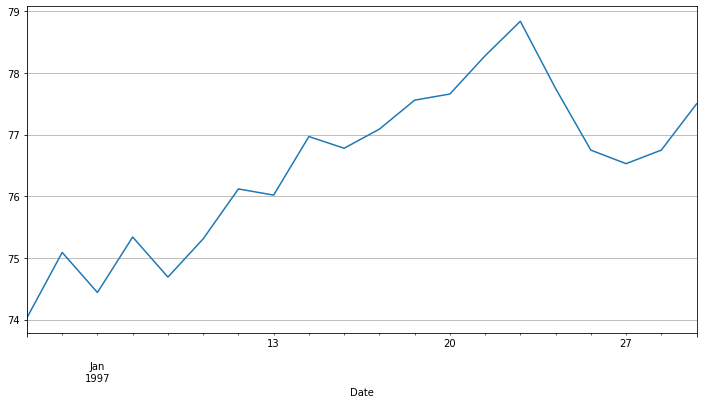

In [11]:
## S&P 20일의 종가 그래프
x_data = train_df[0:20]['Close']
x_data.plot(figsize=(12,6), grid=True);

In [12]:
train_df.iloc[:, 1:].shape
train_df

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1997-01-02,74.03,74.38,74.38,72.75,2030000.0,0.0026
1997-01-03,75.09,74.38,75.12,74.08,2120000.0,0.0143
1997-01-06,74.44,75.09,75.44,74.31,1370000.0,-0.0087
1997-01-07,75.34,74.44,75.47,74.12,939000.0,0.0121
1997-01-08,74.69,75.75,75.78,74.69,1800000.0,-0.0086
...,...,...,...,...,...,...
2015-12-24,205.68,205.72,206.33,205.42,48540000.0,-0.0017
2015-12-28,205.21,204.86,205.26,203.94,65900000.0,-0.0023
2015-12-29,207.40,206.51,207.79,206.47,92640000.0,0.0107


In [26]:
## train 데이터 생성
i = 0
train_label_list = []

while True:
  ## change <= 0 이면 하락 [label = 0] , change> 0 이면 상승 [label = 1]
  try:
    change = train_df.iloc[i+20]['Change']
  except:
    break
  if change <= 0 :
    label = 0
  if change > 0 :
    label = 1
  train_label_list.append(label)

  ## 하루씩 밀려가며 20일치 종가 그래프를 new_data에 저장
  x_data = train_df[i:i+20]['Close'].values
  min_value = min(x_data)
  max_value = max(x_data)
  x_data = np.array([(x_data - min_value) / (max_value - min_value)])
  if i == 0 :
    train_data = np.array(x_data)
  else:
    train_data = np.concatenate((train_data,np.array(x_data)),axis=0)

  i += 1
# train_data

In [33]:
## test 데이터 생성
i = 0
test_label_list = []
while True:
  ## change <= 0 이면 하락 [label = 0] , change> 0 이면 상승 [label = 1]
  try:
    change = test_df.iloc[i+20]['Change']
  except:
    break
  if change <= 0 :
    label = 0
  if change > 0 :
    label = 1
  test_label_list.append(label)

  ## 하루씩 밀려가며 20일치 종가 그래프를 new_data에 저장
  x_data = test_df[i:i+20]['Close'].values
  
  min_value = min(x_data)
  max_value = max(x_data)
  x_data = np.array([(x_data - min_value) / (max_value - min_value)])

  if i == 0 :
    test_data = np.array(x_data)
  else:
    test_data = np.concatenate((test_data,np.array(x_data)),axis=0)

  i += 1

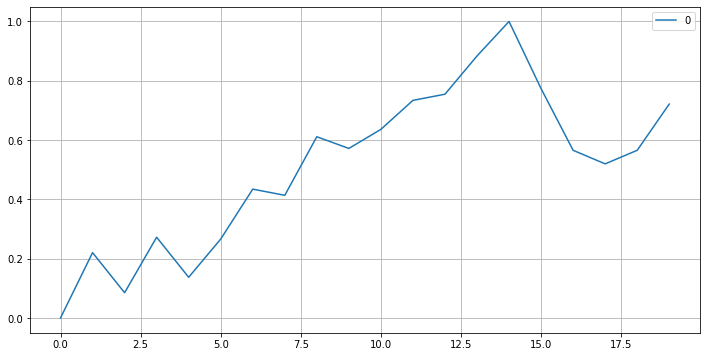

In [32]:
# x_data = train_df[0:20]['Close']
pd.DataFrame(train_data[0]).plot(figsize=(12,6), grid=True);

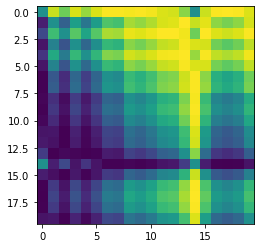

In [35]:
## train_data , test_data GAF를 이용하여 이미지화
from pyts.image import GramianAngularField
from matplotlib.pyplot import imshow
transformer = GramianAngularField(method='difference')
X_train_GAF = transformer.fit_transform(train_data)
X_test_GAF = transformer.fit_transform(test_data)
imshow(X_train_GAF[0])

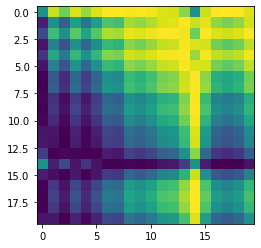

In [36]:
# GAF 이미지 normalize
X_train_GAF_L = (((X_train_GAF + 1) / 2)*255).astype(int)
X_test_GAF_L = (((X_test_GAF + 1) / 2)*255).astype(int)
imshow(X_train_GAF_L[0])

In [37]:
## GAF 이미지 normalize 확인

np.min(X_train_GAF_L), np.max(X_train_GAF_L)

(0, 255)

In [38]:
## data 저장 폴더 생성

!mkdir gaf_images
root_folder = 'gaf_images'

In [40]:
# train / test data check
print(len(train_label_list))
print(len(test_label_list))

4762
1239


# 3. Train (fit)

In [41]:
# save train set images (e.g., train/class_name/0.png)

for i in range(len(train_label_list)):
     
    # define file names
    image_file_name = str(i) + '.png'

    # define folder names
    class_folder_name = str(train_label_list[i])
    full_path = os.path.join(root_folder, 'train')
    full_path = os.path.join(full_path, class_folder_name)
    
    # make folders
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    # save images
    image_file_name_with_full_path = os.path.join(full_path, image_file_name)
    plt.imsave(image_file_name_with_full_path, X_train_GAF_L[i])

In [42]:
# save test set images (e.g., test/class_name/0.png)

for i in range(len(test_label_list)):
     
    # define file names
    image_file_name = str(i) + '.png'

    # define folder names
    class_folder_name = str(test_label_list[i])
    full_path = os.path.join(root_folder, 'test')
    full_path = os.path.join(full_path, class_folder_name)
    
    # make folders
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    # save images
    image_file_name_with_full_path = os.path.join(full_path, image_file_name)
    plt.imsave(image_file_name_with_full_path, X_test_GAF_L[i])

# 4. Predict future

In [43]:
# data block settings

my_random_seed = 32
my_batch_size = 32

In [46]:
from fastai.vision.data import ImageDataLoaders

ImportError: ignored

In [ ]:
# predict

forecast = myprophet.predict(future)
forecast

In [ ]:
# plot forecast

myprophet.plot(forecast);

In [ ]:
# plot components of forecast

myprophet.plot_components(forecast);

In [ ]:
# compare actual and forecast

plt.figure(figsize=(12,6))
plt.plot(df_mystock.index, df_mystock['Close'], label='actual')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()